In [107]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [20]:
q = """
    SELECT id, 
           room_type, 
           toFloat32OrNull(replaceRegexpAll(price , '[$,]', '')) as price
    FROM 
        {db}.ldn_listings  
    ORDER BY id ASC    
    LIMIT 1000    
    """
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test.loc[q_test['room_type'] == 'Private room'].describe()

,id,price
count,551.000000,551.000000
mean,342796.900181,66.820328
std,144848.768916,78.609314
min,13913.000000,12.000000
25%,257798.500000,35.500000
50%,388743.000000,49.000000
75%,453442.500000,70.000000
max,542231.000000,1000.000000


In [30]:
q1 = """
    SELECT room_type, 
           toFloat32OrNull(replaceRegexpAll(price , '[$,]', '')) as price,
           toFloat32OrNull(review_scores_rating) as review_scores_rating
    FROM 
        {db}.ldn_listings  
    WHERE isNotNull(review_scores_rating) 
    ORDER BY id ASC
    LIMIT 1000
    """
q1_test = ph.read_clickhouse(query=q1, connection=connection_default)
q1_test = q1_test.groupby('room_type', as_index=False).agg({'price' : 'mean', 'review_scores_rating' : 'mean'})

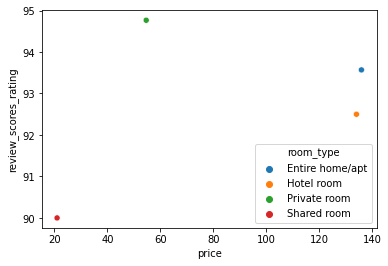

In [31]:
sns.scatterplot(data=q1_test, x='price', y='review_scores_rating', hue='room_type')

In [38]:
q2 = """
    SELECT DISTINCT host_id, 
           host_verifications
    FROM 
        {db}.ldn_listings  
    WHERE experiences_offered != 'none'
    """
q2_test = ph.read_clickhouse(query=q2, connection=connection_default)

In [40]:
q2_test['host_verifications'] = q2_test['host_verifications'].apply(lambda x: [s.strip(" '") for s in x.strip('[]').split(',')])


In [43]:
q2_test.dtypes

host_id               uint32
host_verifications    object
dtype: object

In [44]:
q2_test_exploded = q2_test.explode('host_verifications')
verification_counts = q2_test_exploded['host_verifications'].value_counts()

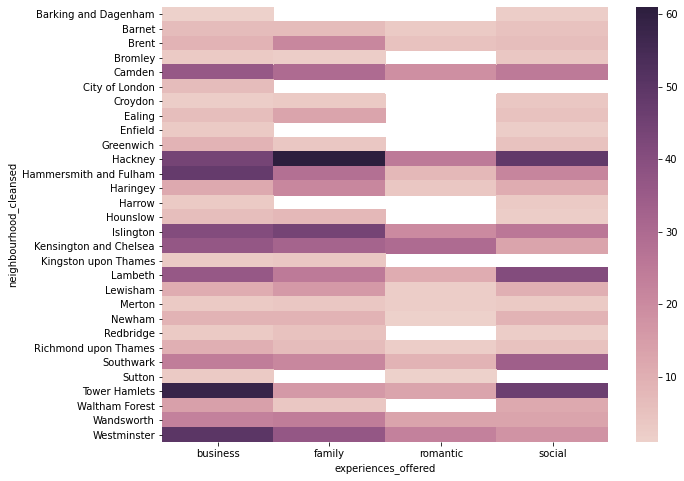

In [92]:
q4 = """
    SELECT neighbourhood_cleansed, 
           experiences_offered,
           COUNT(*) AS experiences_count
    FROM 
        {db}.ldn_listings  
    WHERE experiences_offered != 'none'
    GROUP BY neighbourhood_cleansed, experiences_offered
    ORDER BY experiences_count DESC
    LIMIT 100
    """
q4_test = ph.read_clickhouse(query=q4, connection=connection_default)
q4_test = q4_test.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(experiences_pivot, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

In [96]:
q5 = """
    SELECT room_type, 
           toFloat32OrNull(replaceRegexpAll(price , '[$,]', '')) as price
    FROM 
        {db}.ldn_listings  
    WHERE experiences_offered != 'none'
    """
q5_test = ph.read_clickhouse(query=q5, connection=connection_default)

In [99]:
q5_test.groupby('room_type').head(5)

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
5,Private room,60.0
7,Entire home/apt,100.0
9,Entire home/apt,85.0
13,Entire home/apt,52.0
14,Entire home/apt,400.0


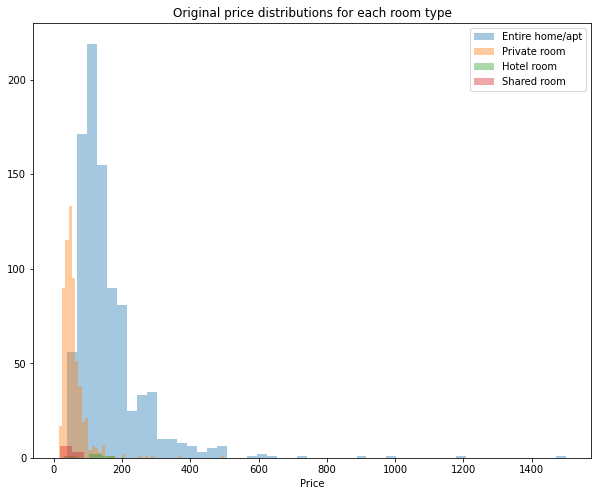

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(q5_test[q5_test['room_type'] == 'Entire home/apt']['price'], kde=False, label='Entire home/apt', ax=ax)
sns.distplot(q5_test[q5_test['room_type'] == 'Private room']['price'], kde=False, label='Private room', ax=ax)
sns.distplot(q5_test[q5_test['room_type'] == 'Hotel room']['price'], kde=False, label='Hotel room', ax=ax)
sns.distplot(q5_test[q5_test['room_type'] == 'Shared room']['price'], kde=False, label='Shared room', ax=ax)
plt.legend()
plt.title('Original price distributions for each room type')
plt.xlabel('Price')

plt.show()

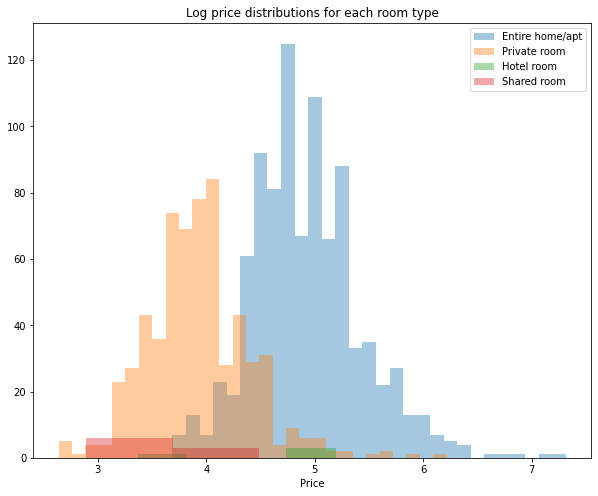

In [108]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(np.log(q5_test[q5_test['room_type'] == 'Entire home/apt']['price']), kde=False, label='Entire home/apt', ax=ax)
sns.distplot(np.log(q5_test[q5_test['room_type'] == 'Private room']['price']), kde=False, label='Private room', ax=ax)
sns.distplot(np.log(q5_test[q5_test['room_type'] == 'Hotel room']['price']), kde=False, label='Hotel room', ax=ax)
sns.distplot(np.log(q5_test[q5_test['room_type'] == 'Shared room']['price']), kde=False, label='Shared room', ax=ax)
plt.legend()
plt.title('Log price distributions for each room type')
plt.xlabel('Price')

plt.show()

In [110]:
q6 = """
    SELECT room_type, 
           toFloat32OrNull(replaceRegexpAll(price , '[$,]', '')) as price,
           first_review
    FROM 
        {db}.ldn_listings  
    WHERE first_review > '2010-01-01'
    LIMIT 1000
    """
q6_test = ph.read_clickhouse(query=q6, connection=connection_default)

In [112]:
q6_test['first_review'] = q6_test['first_review'].apply(lambda x: x[:-6])

In [114]:
q6_test = q6_test.sort_values('first_review')

In [115]:
q6_test

,room_type,price,first_review
0,Private room,65.0,2010
44,Private room,55.0,2010
39,Private room,75.0,2010
38,Entire home/apt,78.0,2010
33,Private room,45.0,2010
...,...,...,...
887,Private room,21.0,2019
277,Private room,105.0,2019
431,Private room,35.0,2019
12,Private room,39.0,2020


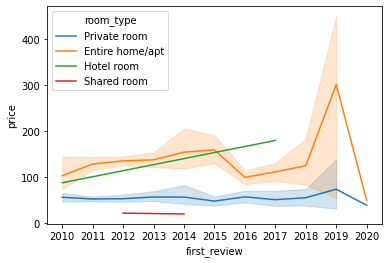

In [116]:
sns.lineplot(data=q6_test, x='first_review', y='price', hue='room_type')